In [1]:
import pysam
import os
import sys
directory_path = os.path.abspath(os.path.join('../src/'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
    
from read_process import get_contig_lengths_dict,\
incorporate_replaced_pos_info,incorporate_insertions_and_deletions,\
get_positions_from_md_tag,reverse_complement,get_edit_information,get_edit_information_wrapper,\
keep_read,has_edits

# Bam example

In [2]:
bampath = '/projects/ps-yeolab5/ekofman/Sammi/MouseBrainEF1A_SingleCell_EPR_batch2/filtered_possorted_ms_hippo_stamp_bam/filtered_keep_xf25_possorted_genome_with_header.bam_MD.bam'


In [3]:
samfile = pysam.AlignmentFile(bampath, "rb")

# Helper functions

In [4]:

contig_lengths_dict = get_contig_lengths_dict(samfile)

In [11]:

def print_read_info(read):
    md_tag = read.get_tag('MD')
    read_id = read.query_name
    cigar_string = read.cigarstring
    barcode = read.get_tag('CR')
    print('MD tag', md_tag)
    print("CIGAR tag", cigar_string)
    print('barcode', barcode)
    

# Full test

In [59]:
from collections import defaultdict
from sys import getsizeof
import time


start_time = time.perf_counter()

barcode_counts = defaultdict(lambda:0)
barcode_to_position_to_alts = defaultdict(lambda:defaultdict(lambda:defaultdict(lambda:defaultdict()))) 
skipped_for_deletions_count = 0 

MAX_READS = 10000000
contig = '1'
reads_for_contig = samfile.fetch(contig, 0, contig_lengths_dict.get(contig))

num_barcodes_to_kb = {}
num_reads_to_kb = {}
num_barcodes_to_seconds = {}
num_reads_to_seconds = {}

for i, read in enumerate(reads_for_contig):
    
    # Keep track of number of reads processed
    if i%10000 == 0:
        #print('Read {}'.format(i))
        kb_size = getsizeof(barcode_to_position_to_alts)/1000
        num_barcodes = len(barcode_to_position_to_alts.keys())
        num_barcodes_to_kb[num_barcodes] = kb_size
        num_reads_to_kb[i] = kb_size
        num_barcodes_to_seconds[num_barcodes] = time.perf_counter() - start_time
        num_reads_to_seconds[i] = time.perf_counter() - start_time

    if i == MAX_READS:
        end_time = time.perf_counter()
        break
        
    md_tag = read.get_tag('MD')
    is_reverse = read.is_reverse
        
    if not is_reverse:
        # FOR NOW SKIP FORWARD READS
        continue
        
    if '^' in md_tag:
        # FOR NOW SKIP DELETIONS, THEY ARE TRICKY TO PARSE...
        skipped_for_deletions_count += 1
        continue
    
    if not has_edits(read):
        continue

    should_keep = keep_read(read)
    
    barcode = read.get_tag('CR')
    barcode_counts[barcode] += 1

    #print_read_info(read)
    #print()

    alt_bases, ref_bases, positions_replaced = get_edit_information_wrapper(read)
    reference_start = read.reference_start
    read_id = read.query_name
    
    for alt, ref, pos in zip(alt_bases, ref_bases, positions_replaced):
        assert(alt != ref)
        barcode_to_position_to_alts[barcode]['{}_{}'.format(pos+reference_start, ref)][alt][read_id] = should_keep
    
    
    
    

# Example dataframe construction

In [69]:
import pandas as pd

all_rows = []
for barcode, pos_dict in barcode_to_position_to_alts.items():
    for pos, alt_dict in pos_dict.items():
        for alt, read_dict in alt_dict.items():
            for read, keep in read_dict.items():
                new_row = (barcode, contig, pos, alt, read, keep)
                all_rows.append(new_row)
            
example_dataframe = pd.DataFrame(all_rows, columns=['barcode', 'contig', 'position_ref', 'alt', 'read_id', 'keep'])

# Time and memory analyses

Text(0.5, 1.0, 'Time vs. number of reads')

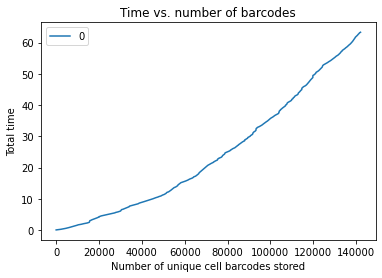

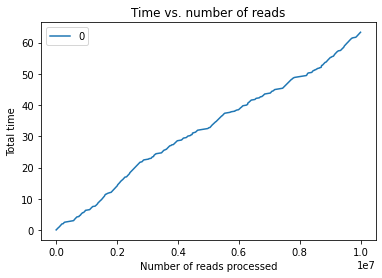

In [61]:
from matplotlib import pyplot as plt

pd.DataFrame.from_dict(num_barcodes_to_seconds, orient='index').plot()
plt.ylabel("Total time")
plt.xlabel("Number of unique cell barcodes stored")
plt.title("Time vs. number of barcodes")

pd.DataFrame.from_dict(num_reads_to_seconds, orient='index').plot()
plt.ylabel("Total time")
plt.xlabel("Number of reads processed")
plt.title("Time vs. number of reads")

In [62]:
import numpy as np

max_reads = np.max(list(num_reads_to_seconds.keys()))
max_seconds = num_reads_to_seconds.get(max_reads)
max_kb = num_reads_to_kb.get(max_reads)
seconds_per_read = max_seconds/max_reads
kb_per_read = max_kb/max_reads
print(seconds_per_read, kb_per_read)

6.332527523813769e-06 0.0005242992000000001


In [63]:
reads_per_cell = 50000
total_cells = 20000
total_reads = reads_per_cell * total_cells
print(total_reads)

1000000000


In [64]:
total_estimated_time = total_reads * seconds_per_read
print('Estimated total time in minutes for {} reads: {} minutes'.format(total_reads, round(total_estimated_time/60), 3))
total_estimated_kb = total_reads * kb_per_read
print('Estimated total kilobytes for {} reads: {} kb'.format(total_reads, total_estimated_kb))


Estimated total time in minutes for 1000000000 reads: 106 minutes
Estimated total kilobytes for 1000000000 reads: 524299.2000000001 kb


Text(0.5, 1.0, 'Memory requirements vs. number of reads')

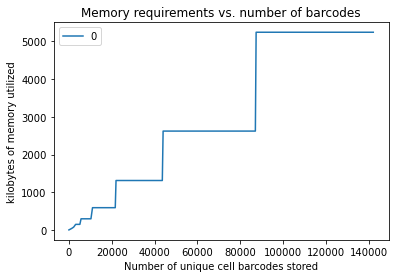

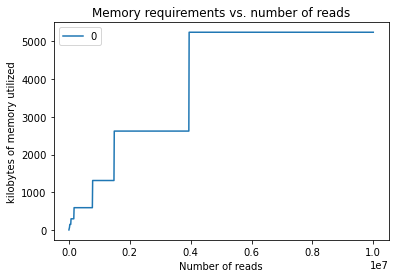

In [65]:
from matplotlib import pyplot as plt

pd.DataFrame.from_dict(num_barcodes_to_kb, orient='index').plot()
plt.ylabel("kilobytes of memory utilized")
plt.xlabel("Number of unique cell barcodes stored")
plt.title("Memory requirements vs. number of barcodes")


pd.DataFrame.from_dict(num_reads_to_kb, orient='index').plot()
plt.ylabel("kilobytes of memory utilized")
plt.xlabel("Number of reads")
plt.title("Memory requirements vs. number of reads")

In [66]:
num_reads_per_barcode_df = pd.DataFrame.from_dict(barcode_counts, orient='index', columns=['reads']).sort_values('reads')

In [67]:
num_reads_per_barcode_df.sum()

reads    683319
dtype: int64

In [68]:
skipped_for_deletions_count

32575